In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
pd.set_option('display.max_rows', 50)
import warnings
import plotly.express as px
from datetime import datetime, date
warnings.filterwarnings("ignore")

try:
    import lime
except:
    !pip install lime
    from lime import lime_tabular

try:
    import lazypredict
except:
    !pip install lazypredict
    from lazypredict.Supervised import LazyClassifier

try:
    import kneed
except:
    !pip install kneed
    from kneed import KneeLocator

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=d0262777fcd21b4642cf7aadac9bb6e48ec174066e3a8263e7a652187ff2618f
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [14]:
#Read datset
df = pd.read_csv('/content/customer_churn_dataset-training-master.csv')
df

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2,30,Female,39,14,5,18,Standard,Annual,932.00,17.00,1.00
1,3,65,Female,49,1,10,8,Basic,Monthly,557.00,6.00,1.00
2,4,55,Female,14,4,6,18,Basic,Quarterly,185.00,3.00,1.00
3,5,58,Male,38,21,7,7,Standard,Monthly,396.00,29.00,1.00
4,6,23,Male,32,20,5,8,Basic,Monthly,617.00,20.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
122974,126920,49,Female,6,6,9,12,Basic,Quarterly,771.00,25.00,1.00
122975,126921,64,Male,57,19,4,8,Standard,Quarterly,218.00,27.00,1.00
122976,126922,25,Female,7,9,3,2,Basic,Monthly,852.00,1.00,1.00
122977,126923,64,Female,31,27,1,18,Basic,Quarterly,610.00,10.00,1.00


In [15]:
# Change column names
df.columns = [i.lower().replace(' ','_') for i in df.columns]
df.columns

Index(['customerid', 'age', 'gender', 'tenure', 'usage_frequency',
       'support_calls', 'payment_delay', 'subscription_type',
       'contract_length', 'total_spend', 'last_interaction', 'churn'],
      dtype='object')

In [16]:
# Check missing values
df.isnull().sum()

customerid           0
age                  0
gender               0
tenure               0
usage_frequency      0
support_calls        0
payment_delay        0
subscription_type    1
contract_length      1
total_spend          1
last_interaction     1
churn                1
dtype: int64

In [17]:
# Drop missing value
df.dropna(axis = 0 , inplace = True)


In [18]:
# Check Duplicated values
df.duplicated().sum()

0

In [19]:
# Check data type
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122978 entries, 0 to 122977
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   customerid         122978 non-null  int64  
 1   age                122978 non-null  int64  
 2   gender             122978 non-null  object 
 3   tenure             122978 non-null  int64  
 4   usage_frequency    122978 non-null  int64  
 5   support_calls      122978 non-null  int64  
 6   payment_delay      122978 non-null  int64  
 7   subscription_type  122978 non-null  object 
 8   contract_length    122978 non-null  object 
 9   total_spend        122978 non-null  float64
 10  last_interaction   122978 non-null  float64
 11  churn              122978 non-null  float64
dtypes: float64(3), int64(6), object(3)
memory usage: 12.2+ MB


In [20]:
#Check data accuracy
frame = []
for i in df.columns:
    print('Name of columns: {}'.format(i))
    print('Unique Values: {}'.format(df[i].unique()))
    print('Number of Unique Values: {}'.format(df[i].nunique()))
    print('----------------------------------------------------')

Name of columns: customerid
Unique Values: [     2      3      4 ... 126921 126922 126923]
Number of Unique Values: 122978
----------------------------------------------------
Name of columns: age
Unique Values: [30 65 55 58 23 51 39 64 29 52 22 48 24 49 19 47 42 57 27 59 21 60 35 18
 56 20 63 25 28 32 38 37 31 53 41 33 26 36 44 34 61 40 45 46 54 43 50 62]
Number of Unique Values: 48
----------------------------------------------------
Name of columns: gender
Unique Values: ['Female' 'Male']
Number of Unique Values: 2
----------------------------------------------------
Name of columns: tenure
Unique Values: [39 49 14 38 32 33 37 12  3 18 21 41 35  4 56 44 15 55 43 52 26  2 29 59
 40 51 53 24 30  6 28 17 60  7 34 10  5 45 54 58 25 13 47 31 22 19 23  1
  8 46 16 50 48 11 42 27  9 20 57 36]
Number of Unique Values: 60
----------------------------------------------------
Name of columns: usage_frequency
Unique Values: [14  1  4 21 20 25 12  8  5  9  6 17 23 13 16 27  2 28 29 15 24  3 22 2

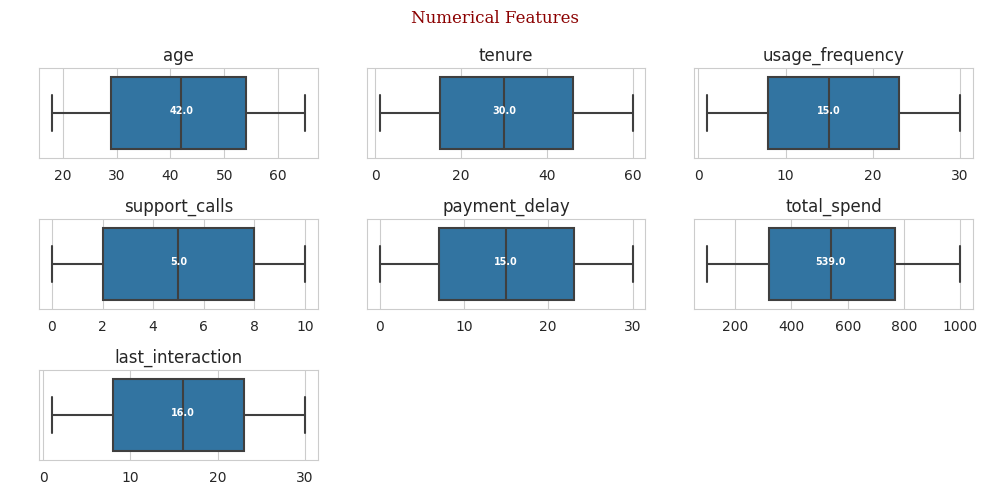

In [21]:
# Check numerical columns
col_features = df.select_dtypes(['float64' , 'int64'])
col_features = col_features[['age', 'tenure', 'usage_frequency', 'support_calls','payment_delay', 'total_spend', 'last_interaction']]
#Create font
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 13,
        }

fig = plt.figure(figsize = (10,5))
fig.suptitle('Numerical Features' , fontdict = font)
for i,j in enumerate(col_features):
    ax = fig.add_subplot(3,3,i+1)
    ax = sns.boxplot(data = col_features , x = j)
    #Calculate median
    median = df[j].median()
    #Plot median in the graph
    ax.text(median , ax.get_yticks(), s = '{}'.format(median)  ,horizontalalignment='center',size='x-small',color='w',weight='semibold')
    ax.set_ylabel(' ')
    ax.set_xlabel('')
    ax.set_title(j)

plt.tight_layout()


In [22]:
# Additional Info
col_features.describe().T

,count,mean,std,min,25%,50%,75%,max
age,122978.00,41.65,13.94,18.00,29.00,42.00,54.00,65.00
tenure,122978.00,30.47,17.35,1.00,15.00,30.00,46.00,60.00
usage_frequency,122978.00,15.47,8.67,1.00,8.00,15.00,23.00,30.00
support_calls,122978.00,5.11,3.15,0.00,2.00,5.00,8.00,10.00
payment_delay,122978.00,15.16,8.97,0.00,7.00,15.00,23.00,30.00
total_spend,122978.00,544.08,259.59,100.00,320.00,539.00,769.00,1000.00
last_interaction,122978.00,15.56,8.66,1.00,8.00,16.00,23.00,30.00


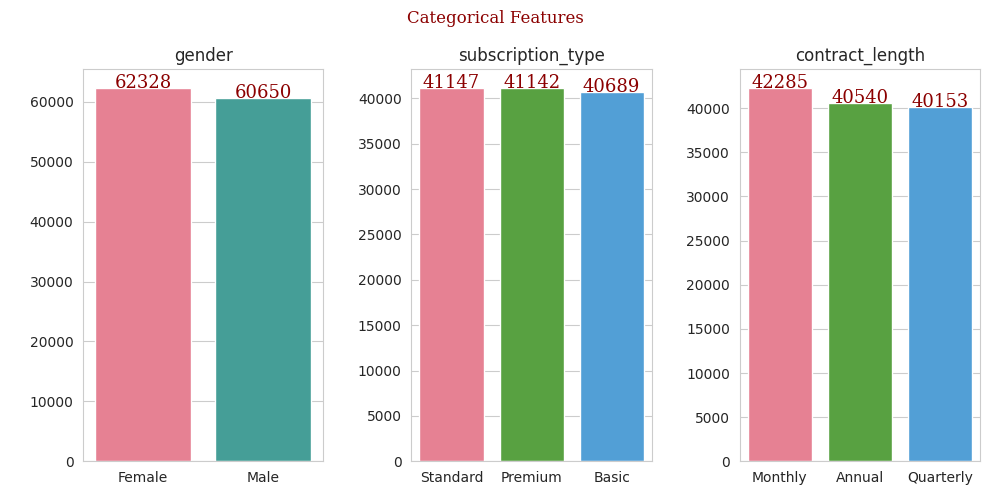

In [23]:
col_categorical = df.select_dtypes('object')

fig = plt.figure(figsize = (10,5))
fig.suptitle('Categorical Features' , fontdict = font)
for i,j in enumerate(col_categorical):
    ax = fig.add_subplot(1,3,i+1)
    #Recalculate data frame
    ax = sns.barplot(data = df[j].value_counts().sort_values(ascending = False).to_frame() ,x = df[j].value_counts().sort_values(ascending = False).to_frame().index, y = j , palette = 'husl' )
    #Create text
    text = df[j].value_counts()
    for x,y in enumerate(text):
        ax.text(x,y,y,horizontalalignment='center' , fontdict = font)
    ax.set_ylabel(' ')
    ax.set_xlabel('')
    ax.set_title(j)

plt.tight_layout()


Text(0.5, 1.0, 'Target Variable')

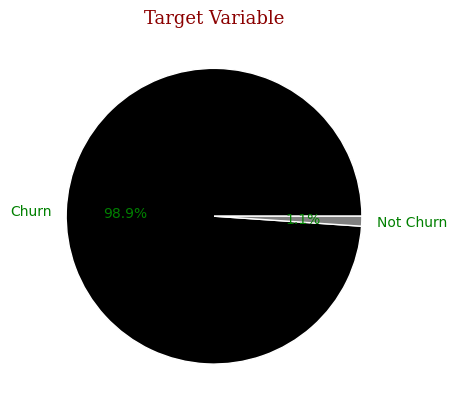

In [24]:
# Target variable
plt.pie(data = df['churn'].value_counts().to_frame() ,labels = ['Churn','Not Churn'], x = 'churn' , autopct = '%1.1f%%' ,colors = ['black','grey'],textprops={'color':"g"} )
plt.title('Target Variable' , fontdict = font)

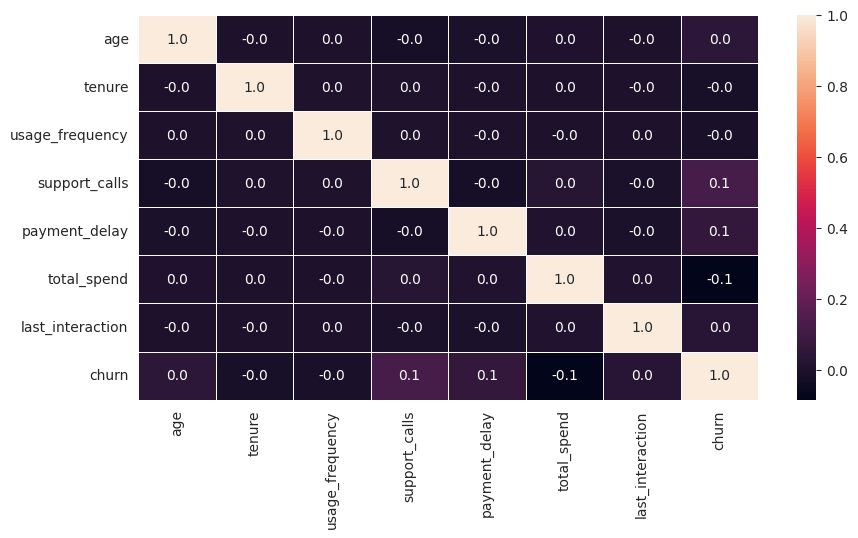

In [25]:
matrix = df[['age', 'gender', 'tenure', 'usage_frequency','support_calls', 'payment_delay','contract_length', 'total_spend', 'last_interaction','churn']]

fig,ax=plt.subplots(figsize = (10,5))
sns.heatmap(matrix.corr(),annot= True,linewidths=0.5,fmt = ".1f",ax=ax);

In [26]:
df1 = df.copy()
df1

,customerid,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn
0,2,30,Female,39,14,5,18,Standard,Annual,932.00,17.00,1.00
1,3,65,Female,49,1,10,8,Basic,Monthly,557.00,6.00,1.00
2,4,55,Female,14,4,6,18,Basic,Quarterly,185.00,3.00,1.00
3,5,58,Male,38,21,7,7,Standard,Monthly,396.00,29.00,1.00
4,6,23,Male,32,20,5,8,Basic,Monthly,617.00,20.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
122973,126919,24,Male,52,23,4,28,Premium,Quarterly,385.00,13.00,1.00
122974,126920,49,Female,6,6,9,12,Basic,Quarterly,771.00,25.00,1.00
122975,126921,64,Male,57,19,4,8,Standard,Quarterly,218.00,27.00,1.00
122976,126922,25,Female,7,9,3,2,Basic,Monthly,852.00,1.00,1.00


In [27]:
# Label encode data
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df1['gender'] = le.fit_transform(df1['gender'])
df1['subscription_type'] = le.fit_transform(df1['subscription_type'])
df1['contract_length'] = le.fit_transform(df1['contract_length'])
df1


,customerid,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn
0,2,30,0,39,14,5,18,2,0,932.00,17.00,1.00
1,3,65,0,49,1,10,8,0,1,557.00,6.00,1.00
2,4,55,0,14,4,6,18,0,2,185.00,3.00,1.00
3,5,58,1,38,21,7,7,2,1,396.00,29.00,1.00
4,6,23,1,32,20,5,8,0,1,617.00,20.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
122973,126919,24,1,52,23,4,28,1,2,385.00,13.00,1.00
122974,126920,49,0,6,6,9,12,0,2,771.00,25.00,1.00
122975,126921,64,1,57,19,4,8,2,2,218.00,27.00,1.00
122976,126922,25,0,7,9,3,2,0,1,852.00,1.00,1.00


In [28]:
# Drop unused column
df1.drop(columns = 'customerid' , inplace = True)

In [29]:
df1.columns

Index(['age', 'gender', 'tenure', 'usage_frequency', 'support_calls',
       'payment_delay', 'subscription_type', 'contract_length', 'total_spend',
       'last_interaction', 'churn'],
      dtype='object')

In [30]:
# Scale Data

from sklearn.preprocessing import StandardScaler

#Import model
scaler = StandardScaler()

#Choose columns
numerical_columns = ['age','tenure', 'usage_frequency', 'support_calls',
       'payment_delay', 'total_spend','last_interaction']

#Copy Dataframe
df1_scaled = df1.copy()

#Transform each column
for i in numerical_columns:
    df1_scaled[i] = scaler.fit_transform(df1_scaled[[i]])

In [31]:
df1_scaled

,age,gender,tenure,usage_frequency,support_calls,payment_delay,subscription_type,contract_length,total_spend,last_interaction,churn
0,-0.84,0,0.49,-0.17,-0.03,0.32,2,0,1.49,0.17,1.00
1,1.67,0,1.07,-1.67,1.55,-0.80,0,1,0.05,-1.10,1.00
2,0.96,0,-0.95,-1.32,0.28,0.32,0,2,-1.38,-1.45,1.00
3,1.17,1,0.43,0.64,0.60,-0.91,2,1,-0.57,1.55,1.00
4,-1.34,1,0.09,0.52,-0.03,-0.80,0,1,0.28,0.51,1.00
...,...,...,...,...,...,...,...,...,...,...,...
122973,-1.27,1,1.24,0.87,-0.35,1.43,1,2,-0.61,-0.30,1.00
122974,0.53,0,-1.41,-1.09,1.23,-0.35,0,2,0.87,1.09,1.00
122975,1.60,1,1.53,0.41,-0.35,-0.80,2,2,-1.26,1.32,1.00
122976,-1.19,0,-1.35,-0.75,-0.67,-1.47,0,1,1.19,-1.68,1.00


In [32]:
df_cluster = df1_scaled[['usage_frequency','support_calls','tenure','payment_delay','total_spend']]
df_cluster

,usage_frequency,support_calls,tenure,payment_delay,total_spend
0,-0.17,-0.03,0.49,0.32,1.49
1,-1.67,1.55,1.07,-0.80,0.05
2,-1.32,0.28,-0.95,0.32,-1.38
3,0.64,0.60,0.43,-0.91,-0.57
4,0.52,-0.03,0.09,-0.80,0.28
...,...,...,...,...,...
122973,0.87,-0.35,1.24,1.43,-0.61
122974,-1.09,1.23,-1.41,-0.35,0.87
122975,0.41,-0.35,1.53,-0.80,-1.26
122976,-0.75,-0.67,-1.35,-1.47,1.19


In [33]:
from sklearn.cluster import KMeans
from kneed import KneeLocator

inertia = []
num_clusters = list(range(1,10))

for k in num_clusters:
    #Instantiate model in range k
    kmeans = KMeans(n_clusters = k)
    #fit model
    kmeans.fit(df_cluster)
    #append the SSE in k cluster to the list
    inertia.append(kmeans.inertia_)

In [35]:
# Find the elbow spot
cost_kneed = KneeLocator(x = num_clusters , y = inertia , S = 1.0 , curve = 'convex' , direction = 'decreasing' , online = True)
K_cost_c3 = cost_kneed.elbow
print('Elbow at k = {} clusters'.format(K_cost_c3))

Elbow at k = 4 clusters


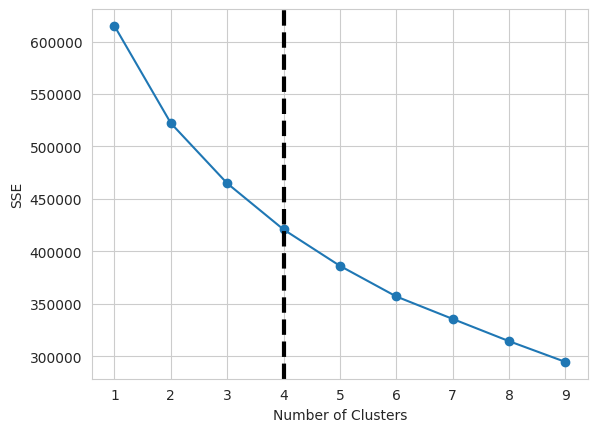

In [36]:
#Plot the graph
plt.plot(num_clusters , inertia , 'o-')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
#plot vertical line at the elbow spot
plt.axvline(x=K_cost_c3, color='black', label='axvline-fullheight', ls='--', linewidth=3)

In [37]:
model = KMeans(n_clusters = 4)
model.fit(df_cluster)

KMeans(n_clusters=4)

In [38]:
model.labels_

array([3, 3, 0, ..., 1, 0, 1], dtype=int32)

In [39]:
#assign cluster in data set
df['cluster'] = model.labels_
# +1 cluster
df['cluster'] = df['cluster'].apply(lambda x : x+1)

In [40]:
dfs = df[['usage_frequency','support_calls','tenure','payment_delay','total_spend','cluster']]

Text(0.5, 1.0, 'Heat map of Median in each cluster')

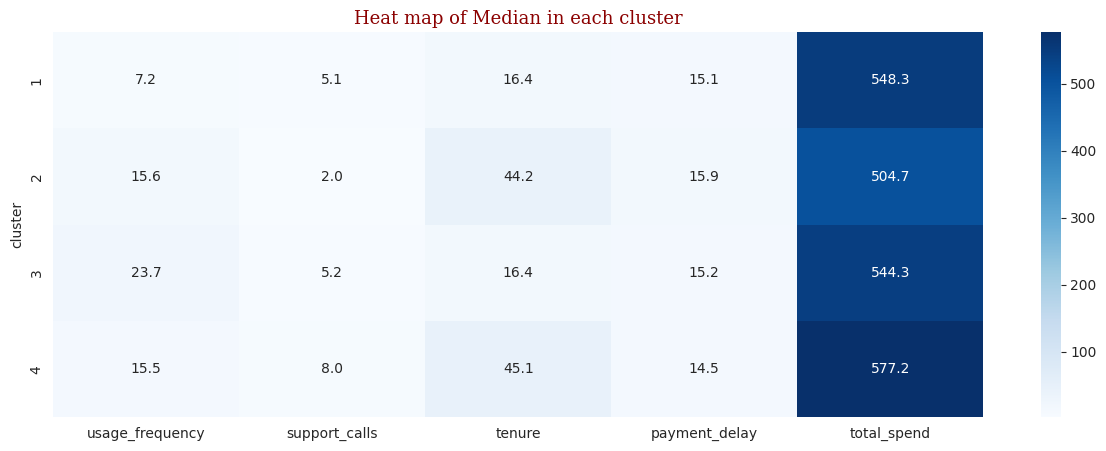

In [41]:
median = dfs.groupby('cluster')['usage_frequency','support_calls','tenure','payment_delay','total_spend'].mean()
fig = plt.figure(figsize = (15,5))
sns.heatmap(data = median , cmap = 'Blues' , annot = True, fmt = ".1f" )
plt.title('Heat map of Median in each cluster' , fontdict = font)

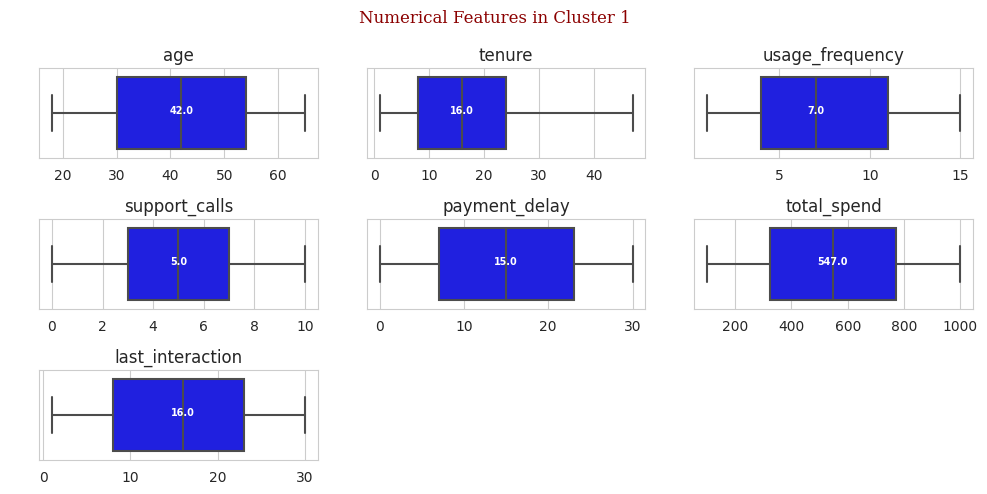

In [42]:
cluster_1 = df[df['cluster'] == 1]
# Check numerical columns
cluster_1_num = cluster_1.select_dtypes(['float64' , 'int64'])
cluster_1_num = cluster_1[['age', 'tenure', 'usage_frequency', 'support_calls','payment_delay', 'total_spend', 'last_interaction']]
#Create font
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 13,
        }

fig = plt.figure(figsize = (10,5))
fig.suptitle('Numerical Features in Cluster 1' , fontdict = font)
for i,j in enumerate(col_features):
    ax = fig.add_subplot(3,3,i+1)
    ax = sns.boxplot(data = cluster_1_num , x = j , color = 'blue')
    #Calculate median
    median = cluster_1_num[j].median()
    #Plot median in the graph
    ax.text(median , ax.get_yticks(), s = '{}'.format(median)  ,horizontalalignment='center',size='x-small',color='w',weight='semibold')
    ax.set_ylabel(' ')
    ax.set_xlabel('')
    ax.set_title(j)

plt.tight_layout()


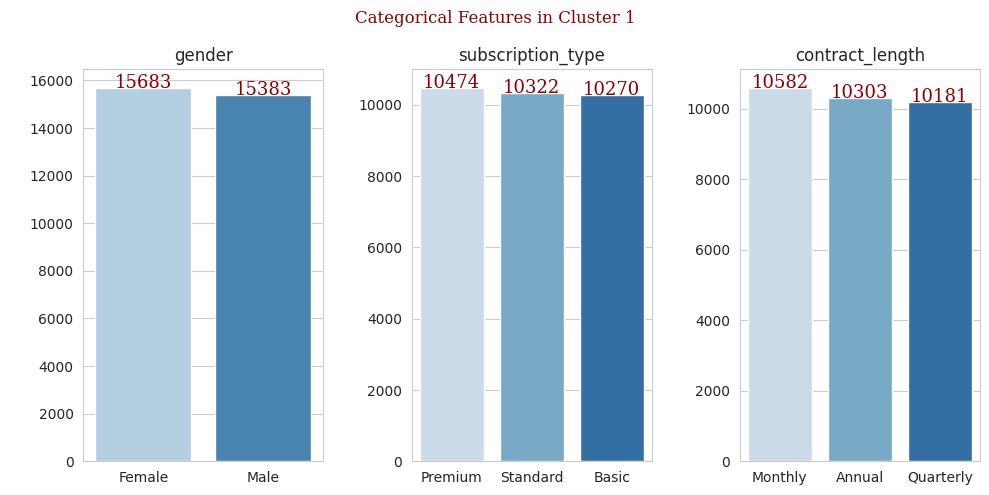

In [43]:
cluster_1_object = cluster_1.select_dtypes('object')

fig = plt.figure(figsize = (10,5))
fig.suptitle('Categorical Features in Cluster 1' , fontdict = font)
for i,j in enumerate(col_categorical):
    ax = fig.add_subplot(1,3,i+1)
    #Recalculate data frame
    ax = sns.barplot(data = cluster_1_object[j].value_counts().sort_values(ascending = False).to_frame() ,x = cluster_1_object[j].value_counts().sort_values(ascending = False).to_frame().index, y = j , palette = 'Blues' )
    #Create text
    text = cluster_1_object[j].value_counts()
    for x,y in enumerate(text):
        ax.text(x,y,y,horizontalalignment='center' , fontdict = font)
    ax.set_ylabel(' ')
    ax.set_xlabel('')
    ax.set_title(j)

plt.tight_layout()


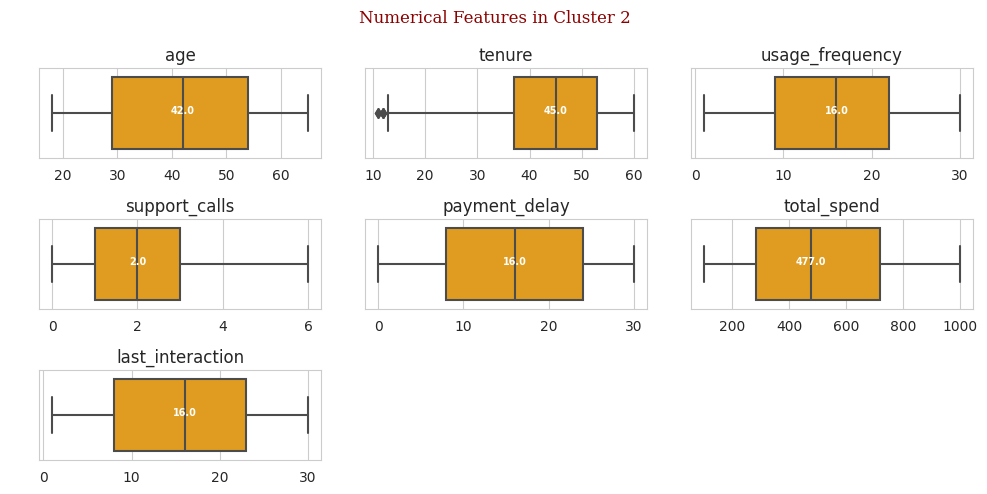

In [44]:
cluster_1 = df[df['cluster'] == 2]
# Check numerical columns
cluster_1_num = cluster_1.select_dtypes(['float64' , 'int64'])
cluster_1_num = cluster_1[['age', 'tenure', 'usage_frequency', 'support_calls','payment_delay', 'total_spend', 'last_interaction']]
#Create font
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 13,
        }

fig = plt.figure(figsize = (10,5))
fig.suptitle('Numerical Features in Cluster 2' , fontdict = font)
for i,j in enumerate(col_features):
    ax = fig.add_subplot(3,3,i+1)
    ax = sns.boxplot(data = cluster_1_num , x = j , color = 'orange')
    #Calculate median
    median = cluster_1_num[j].median()
    #Plot median in the graph
    ax.text(median , ax.get_yticks(), s = '{}'.format(median)  ,horizontalalignment='center',size='x-small',color='w',weight='semibold')
    ax.set_ylabel(' ')
    ax.set_xlabel('')
    ax.set_title(j)

plt.tight_layout()


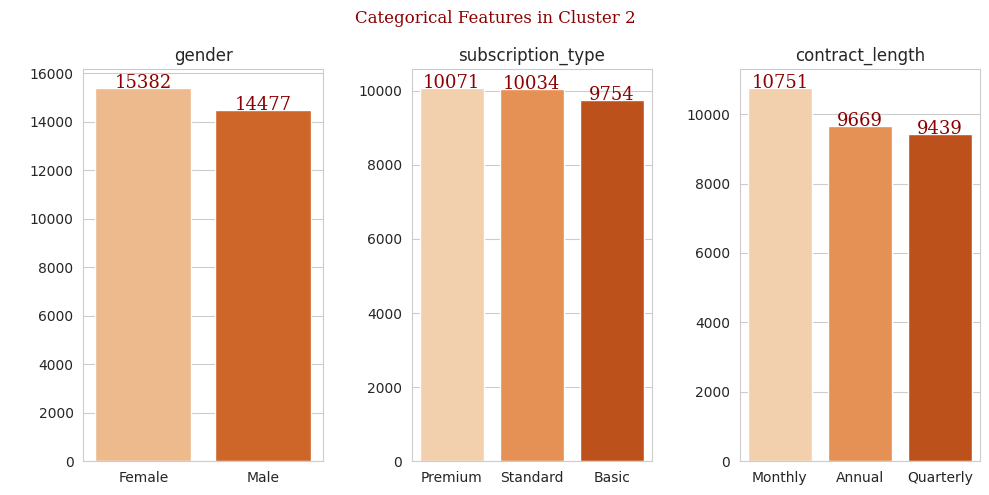

In [45]:
cluster_1_object = cluster_1.select_dtypes('object')

fig = plt.figure(figsize = (10,5))
fig.suptitle('Categorical Features in Cluster 2' , fontdict = font)
for i,j in enumerate(col_categorical):
    ax = fig.add_subplot(1,3,i+1)
    #Recalculate data frame
    ax = sns.barplot(data = cluster_1_object[j].value_counts().sort_values(ascending = False).to_frame() ,x = cluster_1_object[j].value_counts().sort_values(ascending = False).to_frame().index, y = j , palette = 'Oranges' )
    #Create text
    text = cluster_1_object[j].value_counts()
    for x,y in enumerate(text):
        ax.text(x,y,y,horizontalalignment='center' , fontdict = font)
    ax.set_ylabel(' ')
    ax.set_xlabel('')
    ax.set_title(j)

plt.tight_layout()


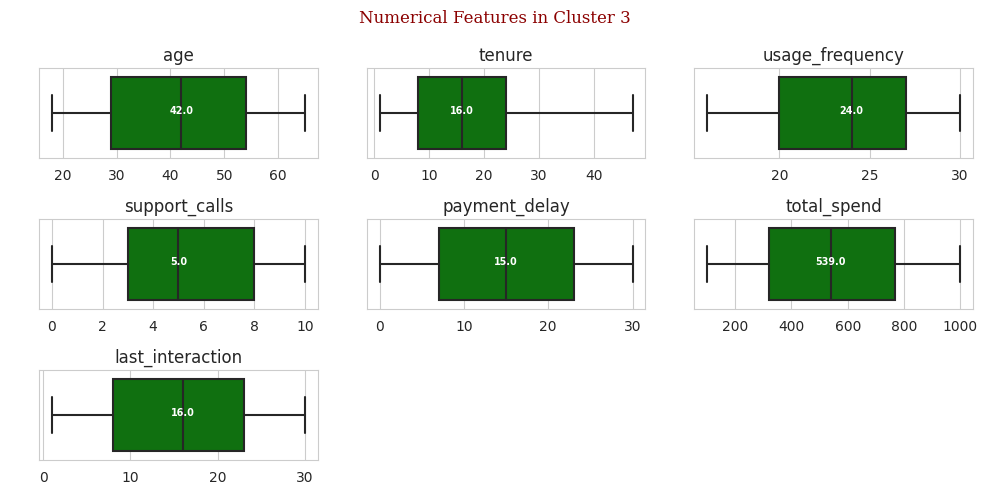

In [46]:
cluster_1 = df[df['cluster'] == 3]
# Check numerical columns
cluster_1_num = cluster_1.select_dtypes(['float64' , 'int64'])
cluster_1_num = cluster_1[['age', 'tenure', 'usage_frequency', 'support_calls','payment_delay', 'total_spend', 'last_interaction']]
#Create font
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 13,
        }

fig = plt.figure(figsize = (10,5))
fig.suptitle('Numerical Features in Cluster 3' , fontdict = font)
for i,j in enumerate(col_features):
    ax = fig.add_subplot(3,3,i+1)
    ax = sns.boxplot(data = cluster_1_num , x = j , color = 'green')
    #Calculate median
    median = cluster_1_num[j].median()
    #Plot median in the graph
    ax.text(median , ax.get_yticks(), s = '{}'.format(median)  ,horizontalalignment='center',size='x-small',color='w',weight='semibold')
    ax.set_ylabel(' ')
    ax.set_xlabel('')
    ax.set_title(j)

plt.tight_layout()


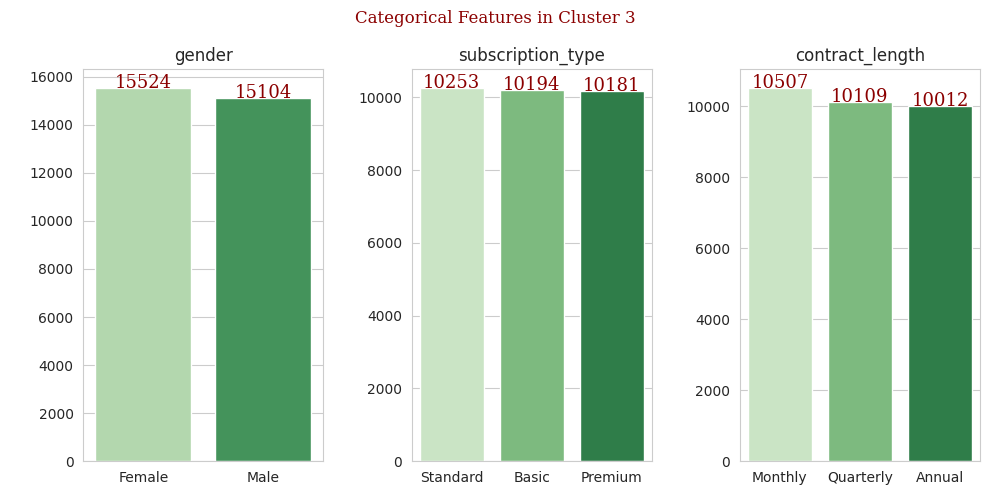

In [47]:
cluster_1_object = cluster_1.select_dtypes('object')

fig = plt.figure(figsize = (10,5))
fig.suptitle('Categorical Features in Cluster 3' , fontdict = font)
for i,j in enumerate(col_categorical):
    ax = fig.add_subplot(1,3,i+1)
    #Recalculate data frame
    ax = sns.barplot(data = cluster_1_object[j].value_counts().sort_values(ascending = False).to_frame() ,x = cluster_1_object[j].value_counts().sort_values(ascending = False).to_frame().index, y = j , palette = 'Greens' )
    #Create text
    text = cluster_1_object[j].value_counts()
    for x,y in enumerate(text):
        ax.text(x,y,y,horizontalalignment='center' , fontdict = font)
    ax.set_ylabel(' ')
    ax.set_xlabel('')
    ax.set_title(j)

plt.tight_layout()


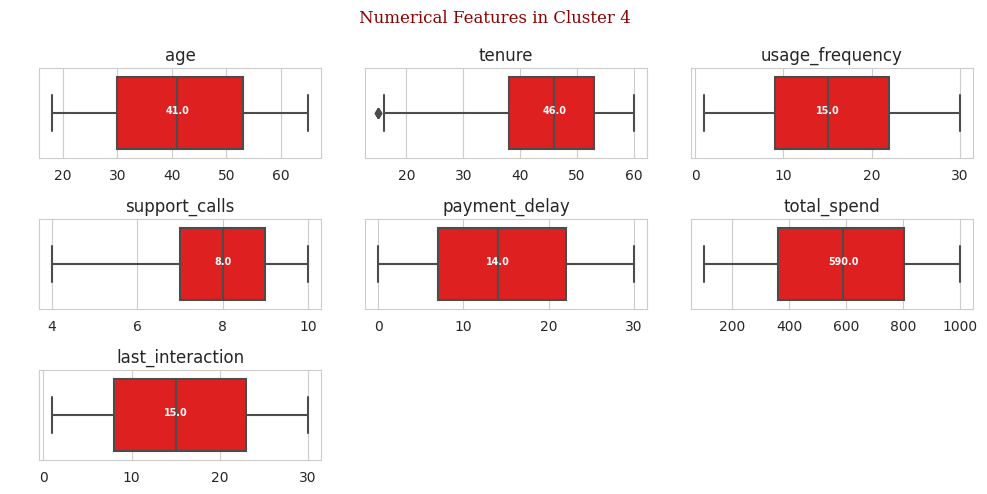

In [48]:
cluster_1 = df[df['cluster'] == 4]
# Check numerical columns
cluster_1_num = cluster_1.select_dtypes(['float64' , 'int64'])
cluster_1_num = cluster_1[['age', 'tenure', 'usage_frequency', 'support_calls','payment_delay', 'total_spend', 'last_interaction']]
#Create font
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 13,
        }

fig = plt.figure(figsize = (10,5))
fig.suptitle('Numerical Features in Cluster 4' , fontdict = font)
for i,j in enumerate(col_features):
    ax = fig.add_subplot(3,3,i+1)
    ax = sns.boxplot(data = cluster_1_num , x = j, color = 'red')
    #Calculate median
    median = cluster_1_num[j].median()
    #Plot median in the graph
    ax.text(median , ax.get_yticks(), s = '{}'.format(median)  ,horizontalalignment='center',size='x-small',color='w',weight='semibold')
    ax.set_ylabel(' ')
    ax.set_xlabel('')
    ax.set_title(j)

plt.tight_layout()


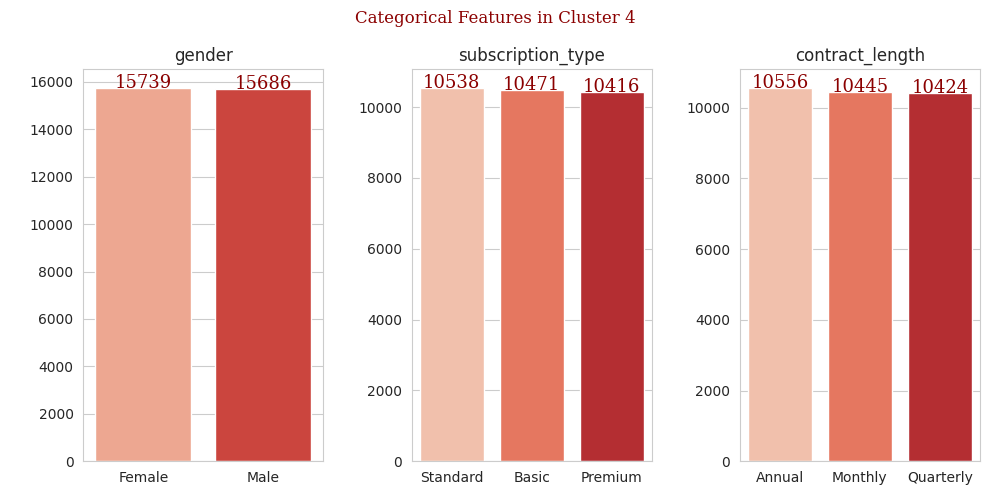

In [49]:
cluster_1_object = cluster_1.select_dtypes('object')

fig = plt.figure(figsize = (10,5))
fig.suptitle('Categorical Features in Cluster 4' , fontdict = font)
for i,j in enumerate(col_categorical):
    ax = fig.add_subplot(1,3,i+1)
    #Recalculate data frame
    ax = sns.barplot(data = cluster_1_object[j].value_counts().sort_values(ascending = False).to_frame() ,x = cluster_1_object[j].value_counts().sort_values(ascending = False).to_frame().index, y = j , palette = 'Reds' )
    #Create text
    text = cluster_1_object[j].value_counts()
    for x,y in enumerate(text):
        ax.text(x,y,y,horizontalalignment='center' , fontdict = font)
    ax.set_ylabel(' ')
    ax.set_xlabel('')
    ax.set_title(j)

plt.tight_layout()


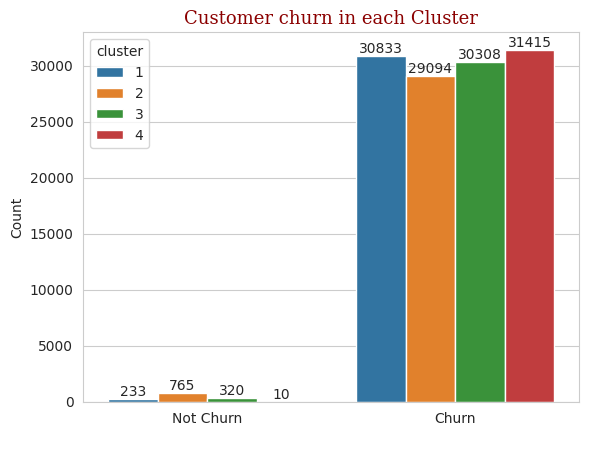

In [50]:
ax = sns.countplot(df , x = 'churn' , hue = 'cluster')
plt.title('Customer churn in each Cluster' , fontdict= font)
plt.xticks(ticks = [0  , 1] , labels = ['Not Churn','Churn'])
plt.xlabel(' ')
plt.ylabel('Count')
for i in ax.containers:
    ax.bar_label(i)

In [51]:
df[df['cluster'] == 3].median()

customerid         63067.00
age                   42.00
tenure                16.00
usage_frequency       24.00
support_calls          5.00
payment_delay         15.00
total_spend          539.00
last_interaction      16.00
churn                  1.00
cluster                3.00
dtype: float64